In [11]:
window_size = 40
EPOCHS = 150
batch_size=256
BUFFER_SIZE=40000
acquisition_cost = 50000000
cost_reactive = acquisition_cost/3
cost_predictive = cost_reactive/3

try:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Thesis/code/
except:
  colab = False

In [12]:
import pandas as pd
import numpy as np
import os
import random 
from emp.losses.prmc.xgboost import XGBObjectiveFunction, XGBMSE, XGBPseudoHuberLoss
from emp.metrics.maintenance import calculate_PRMC
import xgboost as xgb
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import ParameterGrid

import json
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from preprocessing.keras import preprocess_test_windowed_UL, preprocess_train_windowed_UL

In [13]:
def predict_test_set(model, test_x):
    """
    Simulate the model on the testset. 

    @test_x: list of numpy arrays representing the observed sensors throughout time
    """
    predicted_RUL_list = []
    for machine in test_x:
        if 'best_iteration' in dir(model):
          # pred_RUL = np.exp(model.predict(machine,iteration_range=(0,model.best_iteration)))
          pred_RUL = model.predict(machine,iteration_range=(0,model.best_iteration))
          predicted_RUL_list.append(pred_RUL)
        else:
          # pred_RUL = np.exp(model.predict(machine))
          pred_RUL = model.predict(machine)
          predicted_RUL_list.append(pred_RUL) 
    return predicted_RUL_list

def unravel_labels_testset(preds):
  """
  Unravel labels into a np.array 

  Args:
      preds (list[np.array]): list of numpy arrays. Each numpy array corresponds to a machine and every value in such array corresponds to 
                              a prediction for a given moment in time for that specific machine

  """

  out = np.zeros((len(preds),max(list(map(lambda x: len(x),preds)))))
  for row, machine in enumerate(preds):
      out[row, 0:len(machine)] = np.ravel(machine)

  return out

# **Start simulation run:**


In [14]:
def prep_train_val_set(train,validation,window_size=20,name='PRMC'):
    train_x, train_y, train_UL = preprocess_train_windowed_UL(train,window_size=window_size)
    ##Reshape to the right formats:
    train_UL = train_UL.reshape((train_UL.shape[0],))
    train_y=train_y.reshape((train_y.shape[0],))
    scaler = StandardScaler()
    train_x=scaler.fit_transform(train_x.reshape(-1,train_x.shape[-1])).reshape(train_x.shape)
    train_x=train_x.reshape(train_x.shape[0],train_x.shape[1]*train_x.shape[2])
    if name == 'PRMC':
        val_x, val_y, val_UL = preprocess_test_windowed_UL(validation,window_size=window_size)
        val_UL = [tul.reshape((tul.shape[0],)) for tul in val_UL]
        val_y= [y.astype(np.float32) for y in val_y]
        val_x=[scaler.transform(machine.reshape(-1,machine.shape[-1])).reshape(machine.shape) for machine in val_x]
        val_x=[machine.reshape(machine.shape[0],machine.shape[1]*machine.shape[2]) for machine in val_x]
    else:
        val_x, val_y, val_UL = preprocess_train_windowed_UL(validation,window_size=window_size)
        val_UL = val_UL.reshape((val_UL.shape[0],))
        val_y=val_y.reshape((val_y.shape[0],))
        val_x=scaler.transform(val_x.reshape(-1,val_x.shape[-1])).reshape(val_x.shape)
        val_x=val_x.reshape(val_x.shape[0],val_x.shape[1]*val_x.shape[2])




    return ((train_x, train_y, train_UL), (val_x, val_y, val_UL))



In [15]:
shared = True
objective=False
epochs = 15
params={
	"colsample_bytree": 0.9,
	"learning_rate": 0.2,
	"max_depth": 15,
	"subsample": 0.6,
}


train = pd.read_csv('data/gold/train.csv')
validation = pd.read_csv('data/gold/validation.csv')
acquisition_cost=50_000_000


train_data = train
test_data=validation


## create windowed dataset:
basetable_x, basetable_y, train_UL = preprocess_train_windowed_UL(train_data,window_size=window_size)
train_UL = train_UL.reshape((train_UL.shape[0],))

#calculate cost of rul
cost_RUL = acquisition_cost/train_UL 

basetable_y=basetable_y.astype(np.float32)
cost_RUL = cost_RUL.astype(np.float32)
cost_RUL = cost_RUL.reshape((cost_RUL.shape[0],))

if shared:
  cost_RUL= np.mean(cost_RUL)
# same for test set:
basetable_x_test, test_y, test_UL = preprocess_test_windowed_UL(test_data,window_size=window_size)
test_UL = [tul.reshape((tul.shape[0],)) for tul in test_UL]
cost_RUL_test = [(acquisition_cost/ul).astype(np.float32) for ul in test_UL] #calculate cost of rul
test_y= [y.astype(np.float32) for y in test_y]

#### Scale & right format for XGB
scaler = StandardScaler()

train_x, train_y = basetable_x,basetable_y
train_x=scaler.fit_transform(train_x.reshape(-1,train_x.shape[-1])).reshape(train_x.shape)
test_x=[scaler.transform(machine.reshape(-1,machine.shape[-1])).reshape(machine.shape) for machine in basetable_x_test]

## Right format for XGBOOST:
train_x=train_x.reshape(train_x.shape[0],train_x.shape[1]*train_x.shape[2])
test_x=[machine.reshape(machine.shape[0],machine.shape[1]*machine.shape[2]) for machine in test_x]

## Transform to natural logarithm (to enforce the labels to be strictly positive after e^(pred))
train_y[train_y==0] = 1e-6
# train_y=np.log(train_y)

#DATM
train_datm=xgb.DMatrix(train_x,label=train_y)
test_x=[xgb.DMatrix(item) for item in test_x ]

if not objective:
  #obj function, not specified, so choose prmcloss:
  objf = XGBObjectiveFunction(cost_reactive, cost_predictive, cost_RUL)
else:
  objf = objective

if type(objf) == str:
  bst = xgb.XGBRegressor(params, num_boost_round=epochs, obj=objf)
  bst.fit(train_datm)
else:
  bst = xgb.train(params, train_datm, num_boost_round=epochs, obj=objf,evals=[(train_datm,'train')], custom_metric=objf.metric)

preds_iter = unravel_labels_testset(predict_test_set(bst,test_x))
trues_iter = unravel_labels_testset(test_y)
cost_rul_iter = np.array([item[0] for item in cost_RUL_test])


Initialized objective function with shared costs
[0]	train-rmse:120.27152	train-PRMCL:26612572.00000
[1]	train-rmse:111.96204	train-PRMCL:25042866.00000
[2]	train-rmse:104.23276	train-PRMCL:23551218.00000
[3]	train-rmse:97.00920	train-PRMCL:22184766.00000
[4]	train-rmse:90.24916	train-PRMCL:20935084.00000
[5]	train-rmse:83.89307	train-PRMCL:19806426.00000
[6]	train-rmse:78.07257	train-PRMCL:18810086.00000
[7]	train-rmse:72.61678	train-PRMCL:17926516.00000
[8]	train-rmse:67.59152	train-PRMCL:17154498.00000
[9]	train-rmse:63.01994	train-PRMCL:16483734.00000
[10]	train-rmse:59.03857	train-PRMCL:15967890.00000
[11]	train-rmse:55.47326	train-PRMCL:15538744.00000
[12]	train-rmse:52.47849	train-PRMCL:15213411.00000
[13]	train-rmse:49.64774	train-PRMCL:14908278.00000
[14]	train-rmse:47.27535	train-PRMCL:14686567.00000


In [16]:
preds = preds_iter
trues = trues_iter
cost_rul = cost_rul_iter
cost_reactive=50_000_000/3
cost_predictive=cost_reactive/3

title_font = {'size':22}
label_font = {'size':14}


tau = 12

# Analysis

#### One model simulation run:

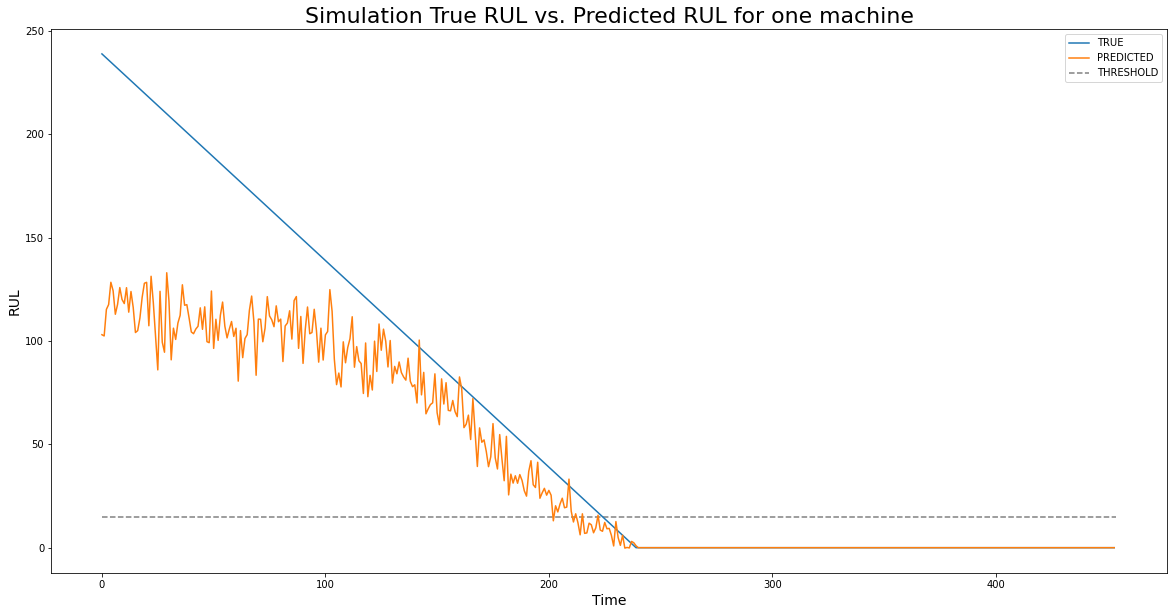

In [17]:
mach = 15

plt.figure(figsize=(20,10))
thresh = np.argmin([np.sum(calculate_PRMC(preds,trues,tau,ti,cost_reactive,cost_predictive,np.mean(cost_rul))) for ti in np.linspace(0.01,150,151)])
plt.plot(np.arange(0,len(trues[mach])),trues[mach],label='TRUE')
plt.plot(np.arange(0,len(preds[mach])),preds[mach],label='PREDICTED')
plt.hlines(thresh,0,len(preds[mach]),linestyles='--',color='gray',label='THRESHOLD')
plt.xlabel('Time',fontdict=label_font)
plt.ylabel('RUL',fontdict=label_font)
plt.title('Simulation True RUL vs. Predicted RUL for one machine',fontdict=title_font)
plt.legend()

### Summed

Shared:

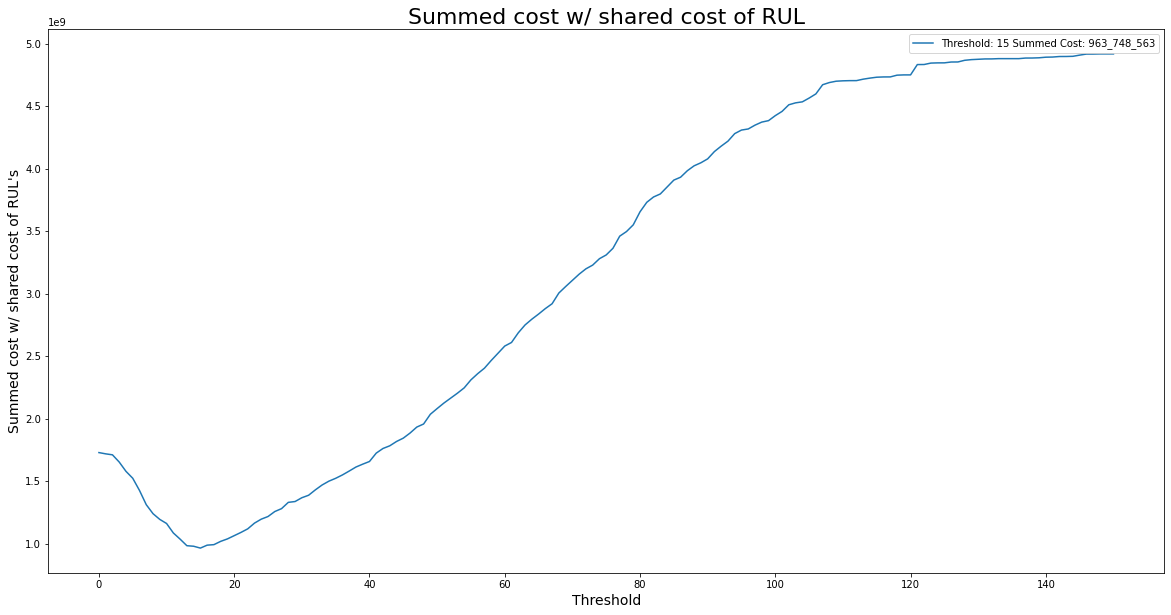

In [18]:
t = np.linspace(0.01,150,151)
plt.figure(figsize=(20,10))

all_costs_to_plot=list()
if type(preds) == list:
    for iter in range(len(preds)):
        costs_to_plot = [np.sum(calculate_PRMC(preds[iter],trues[iter],tau,ti,cost_reactive,cost_predictive,np.mean(cost_rul[iter]))) for ti in t]
        all_costs_to_plot.append(costs_to_plot)
        plt.plot(t,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Summed Cost: {round(np.min(costs_to_plot)):_}',linestyle='--')

else:
    costs_to_plot = [np.sum(calculate_PRMC(preds,trues,tau,ti,cost_reactive,cost_predictive,np.mean(cost_rul))) for ti in t]
    plt.plot(t,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Summed Cost: {round(np.min(costs_to_plot)):_}')

# plt.plot(t,np.mean(all_costs_to_plot,axis=0),label=f'(AVG) Threshold: {np.argmin(np.mean(all_costs_to_plot,axis=0))} Summed Cost: {round(np.min(np.mean(all_costs_to_plot,axis=0))):_}',linewidth=2.5,linestyle='-')
plt.title('Summed cost w/ shared cost of RUL',fontdict=title_font)
plt.xlabel('Threshold',fontdict=label_font)
plt.ylabel('Summed cost w/ shared cost of RUL\'s',fontdict=label_font)
plt.legend()



Individual:

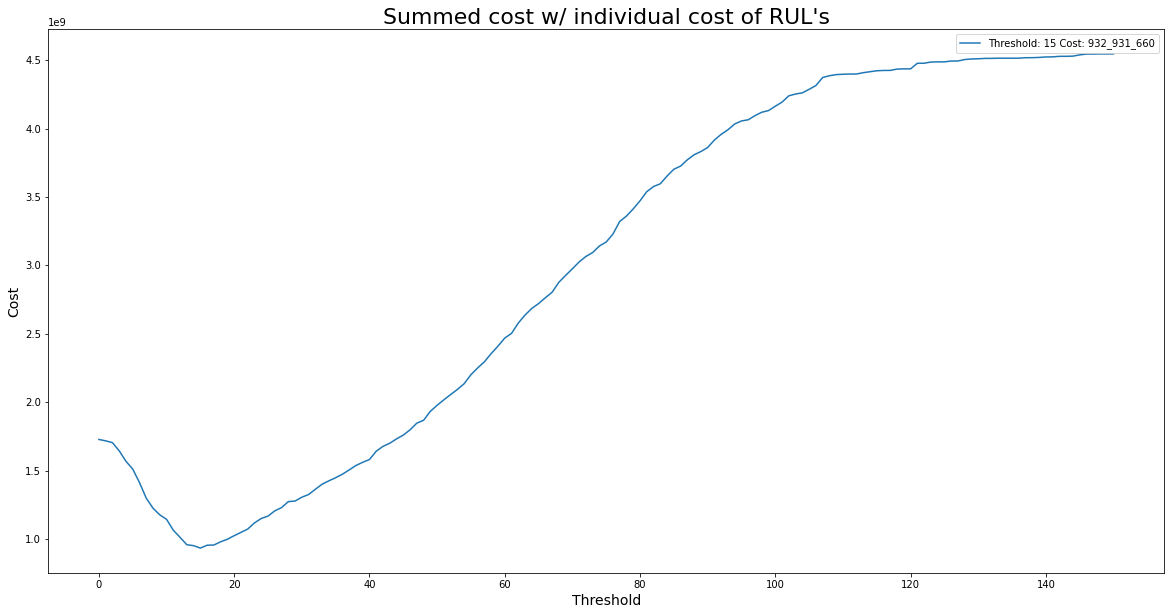

In [19]:
t = np.linspace(0.01,150,151)
plt.figure(figsize=(20,10))

all_costs_to_plot = list()
if type(preds) == list:
    for iter in range(len(preds)):
        costs_to_plot = [np.sum(calculate_PRMC(preds[iter],trues[iter],tau,ti,cost_reactive,cost_predictive,cost_rul[iter])) for ti in t]
        all_costs_to_plot.append(costs_to_plot)
        plt.plot(t,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Cost: {round(np.min(costs_to_plot)):_}',linestyle='--')
else:
    costs_to_plot = [np.sum(calculate_PRMC(preds,trues,tau,ti,cost_reactive,cost_predictive,cost_rul)) for ti in t]
    plt.plot(t,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Cost: {round(np.min(costs_to_plot)):_}')

# plt.plot(t,np.mean(all_costs_to_plot,axis=0),label=f'(AVG) Threshold: {np.argmin(np.mean(all_costs_to_plot,axis=0))} Summed Cost: {round(np.min(np.mean(all_costs_to_plot,axis=0))):_}',linewidth=2.5,linestyle='-')

plt.title('Summed cost w/ individual cost of RUL\'s',fontdict=title_font)
plt.xlabel('Threshold',fontdict=label_font)
plt.ylabel('Cost',fontdict=label_font)
plt.legend()

### Distribution of costs

Text(0.5, 1.0, 'Distribution of types of costs.')

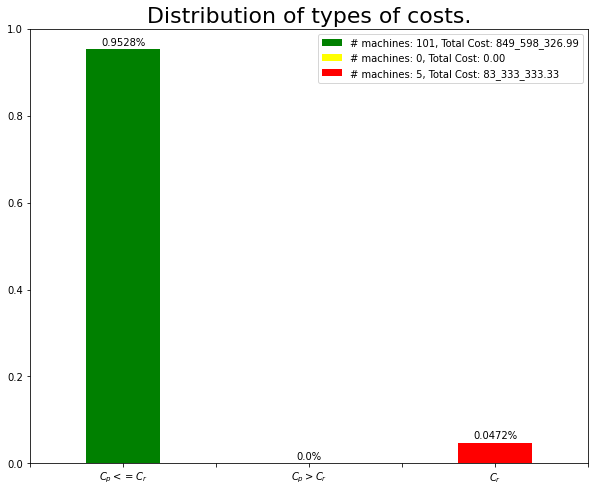

In [20]:
#this only looks at the hypothetical moment of maintenance and failure. The moments still need to be compared
all_PDM=list()
all_failures=list()

threshold = np.argmin(costs_to_plot)


PdM = [(r,np.amin(np.where(preds<=threshold)[1][np.where(preds<=threshold)[0]==r]))for r in set(np.where(preds<=threshold)[0])]
failures = [(r,np.amin(np.where(trues==0)[1][np.where(trues==0)[0]==r])) for r in set(np.where(trues==0)[0])]
all_PDM.append(PdM)
all_failures.append(failures)

cost = np.zeros((len(preds),2))
for idx, (true, pred) in enumerate(zip(failures,PdM)):
    diff_rul = true[1]-pred[1]-tau
    if diff_rul >=0:
        if type(cost_rul) != np.ndarray:
            cost[true[0]][0]=diff_rul * cost_rul[idx] +cost_predictive #take the cost_rul of the corresponding machine
        else:
            cost[true[0]][0]=diff_rul * cost_rul[true[0]] +cost_predictive #take the cost_rul of the corresponding machine
    else:
        cost[true[0]][1]=cost_reactive

failed_machs = sum(cost[:,1])/cost_reactive
predicted_machs = len(cost)-failed_machs
predicted_machs_expensive = len(cost[cost>cost_reactive])
predicted_machs_cheap = predicted_machs-predicted_machs_expensive

failed_machs_ratio=round(failed_machs/cost.shape[0],4)
predicted_machs_expensive_ratio=round(predicted_machs_expensive/cost.shape[0],4)
predicted_machs_cheap_ratio=round(predicted_machs_cheap/cost.shape[0],4)

fig=plt.figure(figsize=(10,8))
fig.patch.set_facecolor('white')
data=[predicted_machs_cheap_ratio,predicted_machs_expensive_ratio,failed_machs_ratio]
labels = [f'# machines: {int(predicted_machs_cheap)}, Total Cost: {np.sum(cost[cost[:,0] <= cost_reactive,0]):_.2f}',
          f'# machines: {int(predicted_machs_expensive)}, Total Cost: {np.sum(cost[cost[:,0] > cost_reactive,0]):_.2f}',
          f'# machines: {int(failed_machs)}, Total Cost: {failed_machs*cost_reactive:_.2f}'
          ]
colors = ['green','yellow','red']
graph = plt.bar([0,2,4],data,color=colors)

for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height+0.01,
             str(p.get_height())+'%',
             ha='center',
             weight='500')


plt.xticks(np.arange(-1,6),labels=['','$C_p <= C_r$','','$C_p > C_r$','','$C_r$',''])

plt.legend(graph,labels)
plt.title(f'Distribution of types of costs.',fontdict=title_font)